# Data Pipeline

This notebook integrates and automates the processes developed in the notebooks for steps 1, 2, and 3. Its main purpose is to jointly execute the following stages: Data Quality Analysis, Metadata Extraction and Transformation into RPCM Entities.

At the end of the workflow, a JSON file is generated, specifically designed for ingestion into Atlas, ensuring proper structuring and availability of the information.

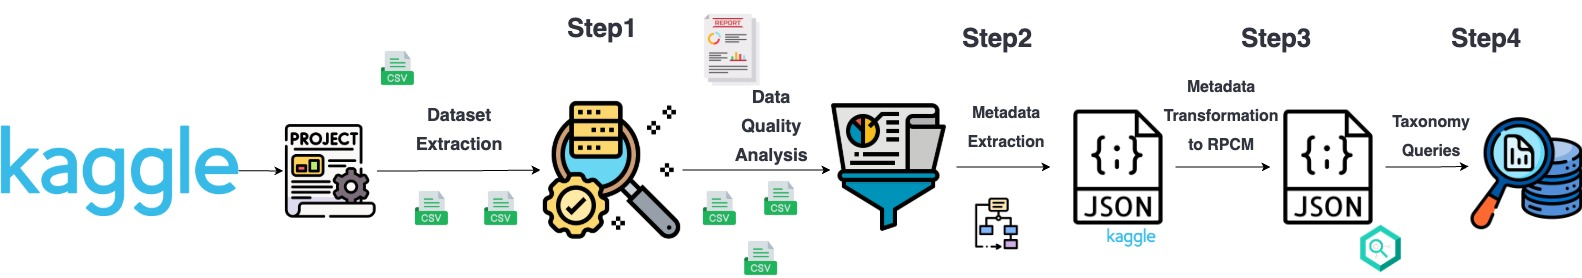

# Set The Project

In [ ]:
pip install kaggle

In [ ]:
import os
import re
import zipfile
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import chardet
from datetime import datetime
import uuid
import nbformat
from pathlib import Path
import hashlib
import base64
import math
from sklearn.impute import SimpleImputer
from collections import Counter

from kaggle.api.kaggle_api_extended import KaggleApi

In [ ]:
os.environ['KAGGLE_USERNAME'] = "abnerasteteh"
os.environ['KAGGLE_KEY'] = "5dec29fba975d4119a37855b3653d27d"

# Authentication
api = KaggleApi()
api.authenticate()

In [ ]:
# Data Quality Configuration
WEIGHTS = {
    "completeness": 0.45,
    "uniqueness": 0.25,
    "outliers": 0.30
}
ALERT_THRESHOLD = 75

In [ ]:
# List of Kaggle projects
kernel_refs = [
    #"joelknapp/student-performance-analysis/",
    "aremoto/retail-sales-forecast/",
]

# Creation of the base directory and complementary functions
base_dir = "kaggle_notebooks"
os.makedirs(base_dir, exist_ok=True)

def safe_name(ref):
    return re.sub(r'[^\w\-]', '_', ref)

def gen_guid():
    return f"-{uuid.uuid4().int % 1000000000}"

# Data Facet

In [ ]:
# =====================================================
# DATA QUALITY FUNCTIONS
# =====================================================
def convert_for_json(obj):
    """Convert Python objects to JSON serializable format"""
    if isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (pd.Timestamp, datetime)):
        return obj.isoformat()
    elif hasattr(obj, 'item'):
        return obj.item()
    elif hasattr(obj, 'tolist'):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_for_json(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_for_json(item) for item in obj]
    return obj

def safe_json_dump(data, file_path, **kwargs):
    """Safely dump data to JSON with proper type conversion"""
    converted_data = convert_for_json(data)
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(converted_data, f, **kwargs)

def extract_csv_metadata(file_path):
    file_path = Path(file_path)
    metadata = {
        'filename': file_path.name,
        'file_path': str(file_path),
        'analysis_timestamp': datetime.now().isoformat(),
        'file_exists': file_path.exists(),
        'file_info': {},
        'csv_schema': {},
        'data_quality': {},
        'errors': []
    }

    if not file_path.exists():
        metadata['errors'].append(f"File not found: {file_path}")
        return metadata

    try:
        stat_info = file_path.stat()
        metadata['file_info'] = {
            'size_bytes': stat_info.st_size,
            'size_mb': round(stat_info.st_size / (1024*1024), 2),
            'creation_time': datetime.fromtimestamp(stat_info.st_ctime).isoformat(),
            'modification_time': datetime.fromtimestamp(stat_info.st_mtime).isoformat(),
            'extension': file_path.suffix.lower(),
        }

        try:
            df_full = pd.read_csv(file_path)

            metadata['csv_schema'] = {
                'total_rows': len(df_full),
                'total_columns': len(df_full.columns),
                'columns': list(df_full.columns),
                'column_types': df_full.dtypes.astype(str).to_dict(),
                'memory_usage_mb': round(df_full.memory_usage(deep=True).sum() / (1024*1024), 2),
                'shape': df_full.shape
            }

            metadata['data_quality'] = {
                'null_values_per_column': df_full.isnull().sum().to_dict(),
                'null_percentage_per_column': (df_full.isnull().sum() / len(df_full) * 100).round(2).to_dict(),
                'total_null_values': int(df_full.isnull().sum().sum()),
                'duplicate_rows': int(df_full.duplicated().sum()),
                'unique_values_per_column': df_full.nunique().to_dict(),
                'completeness_score': round((1 - df_full.isnull().sum().sum() / df_full.size) * 100, 2)
            }

            numeric_columns = df_full.select_dtypes(include=['number']).columns
            if len(numeric_columns) > 0:
                numeric_stats = df_full[numeric_columns].describe().to_dict()
                metadata['numeric_statistics'] = convert_for_json(numeric_stats)

        except Exception as e:
            metadata['errors'].append(f"Error reading CSV: {str(e)}")

    except Exception as e:
        metadata['errors'].append(f"Error accessing file: {str(e)}")

    return metadata

def analyze_multiple_csvs(directory_path):
    directory_path = Path(directory_path)
    analysis_report = {
        'directory': str(directory_path),
        'analysis_timestamp': datetime.now().isoformat(),
        'csv_files_found': 0,
        'files_analysis': {},
        'summary': {'errors': []}
    }

    if not directory_path.exists():
        analysis_report['summary']['errors'].append(f"Directory does not exist: {directory_path}")
        return analysis_report

    csv_files = list(directory_path.glob('*.csv'))
    analysis_report['csv_files_found'] = len(csv_files)

    for csv_file in csv_files:
        print(f"Analyzing: {csv_file.name}")
        file_metadata = extract_csv_metadata(csv_file)
        analysis_report['files_analysis'][csv_file.name] = file_metadata

    return analysis_report

def calculate_completeness(null_percentage_per_column):
    return 100 - np.mean(list(null_percentage_per_column.values()))

def calculate_uniqueness(total_rows, duplicate_rows):
    return max(0, 100 - (duplicate_rows / total_rows * 100))

def calculate_outliers(data):
    penalties = []
    for col, stats in data.get("numeric_statistics", {}).items():
        mean = stats.get("mean", 0)
        std = stats.get("std", 0)
        col_min = stats.get("min", mean)
        col_max = stats.get("max", mean)
        if std > 0:
            if col_min < mean - 3 * std or col_max > mean + 3 * std:
                penalties.append(1)
            else:
                penalties.append(0)
    return 100 - (np.mean(penalties) * 100) if penalties else 100

def calculate_global_score(dataset):
    completeness = calculate_completeness(dataset["data_quality"]["null_percentage_per_column"])
    uniqueness = calculate_uniqueness(dataset["csv_schema"]["total_rows"], dataset["data_quality"]["duplicate_rows"])
    outliers = calculate_outliers(dataset)

    global_score = (
        completeness * WEIGHTS["completeness"] +
        uniqueness * WEIGHTS["uniqueness"] +
        outliers * WEIGHTS["outliers"]
    )

    return {
        "completeness": completeness,
        "uniqueness": uniqueness,
        "outliers": outliers,
        "global_score": global_score
    }

def clean_dataset(file_path, output_dir, lower_quantile=0.05, upper_quantile=0.95, max_missing_frac=0.1):
    df = pd.read_csv(file_path)
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) > 0:
        imputer = SimpleImputer(strategy='median')
        df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        missing_frac = df[col].isna().mean()
        if 0 < missing_frac <= max_missing_frac:
            df = df[df[col].notna()]

    df = df.drop_duplicates()

    for col in numeric_cols:
        lower = df[col].quantile(lower_quantile)
        upper = df[col].quantile(upper_quantile)
        df[col] = np.clip(df[col], lower, upper)

    output_dir.mkdir(exist_ok=True)
    output_path = output_dir / f"clean_{Path(file_path).name}"
    df.to_csv(output_path, index=False)
    print(f"Cleaned dataset saved at {output_path}")
    return output_path

def plot_histograms(file_data, save_dir=None):
    file_path = file_data.get('file_path')
    filename = file_data.get('filename', 'File')

    if not file_path or not Path(file_path).exists():
        print(f"Cannot open {filename} for plotting")
        return

    try:
        df_full = pd.read_csv(file_path)
        available_styles = plt.style.available
        preferred_styles = ['seaborn', 'ggplot', 'fivethirtyeight', 'bmh']
        selected_style = 'classic'

        for style in preferred_styles:
            if style in available_styles:
                selected_style = style
                break

        plt.style.use(selected_style)

        numeric_columns = df_full.select_dtypes(include=['number']).columns
        n = len(numeric_columns)
        if n == 0:
            print("No numeric columns to plot")
            return

        colors = plt.cm.tab10.colors
        cols = min(4, n)
        rows = math.ceil(n / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4.5))
        axes = axes.flatten() if n > 1 else [axes]

        for i, col in enumerate(numeric_columns):
            col_data = df_full[col].dropna()
            unique_vals = col_data.unique()
            num_unique = len(unique_vals)
            bins = num_unique if num_unique <= 15 else 'auto'

            mean_val = col_data.mean()
            median_val = col_data.median()
            std_val = col_data.std()
            skewness = col_data.skew()
            kurt = col_data.kurtosis()

            axes[i].hist(col_data, bins=bins,
                         edgecolor='white',
                         linewidth=1.2,
                         color=colors[i % len(colors)],
                         alpha=0.8)

            axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.2f}')
            axes[i].axvline(median_val, color='green', linestyle='--', linewidth=1.5, label=f'Median: {median_val:.2f}')

            axes[i].set_title(f"Distribution of {col}", pad=15, fontsize=12, fontweight='bold')
            axes[i].set_xlabel(col, labelpad=10)
            axes[i].set_ylabel('Frequency', labelpad=10)
            axes[i].grid(axis='y', alpha=0.3)

            stats_text = (f"Mean: {mean_val:.2f}\n"
                         f"Median: {median_val:.2f}\n"
                         f"Std. Dev.: {std_val:.2f}\n"
                         f"Skewness: {skewness:.2f}\n"
                         f"Kurtosis: {kurt:.2f}")

            axes[i].text(0.95, 0.95, stats_text,
                         transform=axes[i].transAxes,
                         ha='right', va='top',
                         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

            if num_unique <= 15:
                axes[i].set_xticks(np.linspace(col_data.min(), col_data.max(), num=min(10, num_unique)))

            axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

        fig.suptitle(f"Distribution Analysis - {filename}\n(Style: {selected_style})",
                     y=1.02, fontsize=14, fontweight='bold')
        plt.tight_layout()

        if save_dir:
            save_path = save_dir / f"histogram_{Path(filename).stem}.png"
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Histogram saved: {save_path}")

        plt.close()

    except Exception as e:
        print(f"Error plotting {filename}: {e}")

# Source Facet

In [ ]:
def dataset_evaluation(dataset_name):
    owner_slug, dataset_slug = dataset_name.split('/')
    ref = f"{owner_slug}/{dataset_slug}"

    # 1. Basic dataset information
    results = api.dataset_list(search=dataset_slug, user=owner_slug)
    dataset_info = None

    for ds in results:
        if ds.ref == ref:
            dataset_info = {
                "dataset_name": ds.title,
                "subtitle": getattr(ds, "subtitle", ""),
                "description": getattr(ds, "description", ""),
                "license": getattr(ds, "license_name", "Unknown"),
                "author": ds.creator_name,
                "kaggle_id": ref,
                "kaggle_url": f"https://www.kaggle.com/datasets/{ref}",
                "total_downloads": ds.download_count,
                "votes": getattr(ds, 'vote_count', 0),
                "is_private": ds.is_private,
                "is_featured": ds.is_featured,
                "usability_rating": getattr(ds, "usabilityRating", None),
                "download_date": datetime.now().date().isoformat(),
                "creation_date": getattr(ds, "creationDate", "Not available"),
                "last_updated": getattr(ds, "lastUpdated", "Not available")
            }
            break

    if not dataset_info:
        raise ValueError(f"Dataset {ref} not found")

    # 2. Author information (reputation and activity)
    def get_all_datasets(user):
        page = 1
        all_datasets = []
        while True:
            try:
                datasets = api.dataset_list(user=user, page=page)
                if not datasets:
                    break
                all_datasets.extend(datasets)
                page += 1
            except:
                break
        return all_datasets

    def get_all_kernels(user):
        page = 1
        all_kernels = []
        while True:
            try:
                kernels = api.kernels_list(user=user, page=page)
                if not kernels:
                    break
                all_kernels.extend(kernels)
                page += 1
            except:
                break
        return all_kernels

    def get_user_followers(username):
        try:
            user_info = api.user_read(username)
            followers = getattr(user_info, "followerCount", "Not available")
            following = getattr(user_info, "followingCount", "Not available")
            tier = getattr(user_info, "tier", "Not available")
            return followers, following, tier
        except:
            return "Not available", "Not available", "Not available"

    try:
        author_datasets = get_all_datasets(owner_slug)
        total_datasets = len(author_datasets)
        author_notebooks = get_all_kernels(owner_slug)
        total_notebooks = len(author_notebooks)
        followers, following, tier = get_user_followers(owner_slug)

        total_downloads = sum(getattr(ds, 'download_count', 0) for ds in author_datasets)
        total_votes = sum(getattr(ds, 'vote_count', 0) for ds in author_datasets)
        notebook_votes = sum(getattr(nb, 'voteCount', 0) for nb in author_notebooks)

        author_stats = {
            "total_datasets": total_datasets,
            "total_notebooks": total_notebooks,
            "total_dataset_downloads": total_downloads,
            "total_dataset_votes": total_votes,
            "total_notebook_votes": notebook_votes,
            "follower_count": followers,
            "following_count": following,
            "author_tier": tier,
            "avg_downloads_per_dataset": round(total_downloads / total_datasets, 2) if total_datasets > 0 else 0,
            "avg_votes_per_dataset": round(total_votes / total_datasets, 2) if total_datasets > 0 else 0
        }

    except Exception as e:
        print(f"Could not retrieve author statistics: {e}")
        author_stats = {"error": "Author information not available"}

    # 3. Notebooks using this dataset
    try:
        notebooks = api.kernels_list(dataset=ref, page_size=100)
        all_notebooks = notebooks.copy()

        for page in range(2, 6):
            try:
                more_notebooks = api.kernels_list(dataset=ref, page=page, page_size=100)
                if not more_notebooks:
                    break
                all_notebooks.extend(more_notebooks)
            except:
                break

        unique_notebooks = []
        seen_refs = set()
        for nb in all_notebooks:
            if nb.ref not in seen_refs:
                unique_notebooks.append(nb)
                seen_refs.add(nb.ref)

        sorted_notebooks = sorted(unique_notebooks, key=lambda x: getattr(x, 'voteCount', 0), reverse=True)
        total_notebooks_using = len(unique_notebooks)

    except Exception as e:
        print(f"Could not retrieve notebooks: {e}")
        total_notebooks_using = 0

    # 4. Dataset versions (traceability)
    try:
        versions = api.dataset_list_versions(ref)
        version_info = {
            "total_versions": len(versions),
            "current_version": versions[0].versionNumber if versions else 1,
            "version_history": []
        }

        for version in versions[:5]:
            version_info["version_history"].append({
                "version": version.versionNumber,
                "creation_date": getattr(version, "creationDate", "Not available"),
                "status": getattr(version, "status", "Not available")
            })
    except Exception as e:
        print(f"Could not retrieve version information: {e}")
        version_info = {"error": "Version information not available"}

    # 5. Build the reliability assessment with corrected structure
    reliability_assessment = {
        "1_author_info": {
            "author": dataset_info["author"],
            "statistics": author_stats,
            "assessment": "✓ Available" if "error" not in author_stats else "✗ Not available"
        },
        "2_publication_date": {
            "creation_date": dataset_info["creation_date"],
            "last_updated": dataset_info["last_updated"],
            "assessment": "✓ Temporal information available" if dataset_info["creation_date"] != "Not available" else "⚠ Temporal information not available"
        },
        "3_license": {
            "license": dataset_info["license"],
            "assessment": "⚠ Unknown license" if dataset_info["license"] == "Unknown" else f"✓ License: {dataset_info['license']}"
        },
        "4_external_source": {
            "description": dataset_info["description"],
            "assessment": "⚠ No detailed description" if not dataset_info["description"] else "✓ Description available"
        },
        "5_traceability": {
            "versions": version_info,
            "assessment": f"✓ {version_info.get('total_versions', 0)} versions available" if "error" not in version_info else "⚠ No version information"
        },
        "6_description": {
            "title": dataset_info["dataset_name"],
            "subtitle": dataset_info["subtitle"],
            "description": dataset_info["description"],
            "assessment": "✓ Clear title and subtitle" if dataset_info["subtitle"] else "⚠ Limited description"
        },
        "7_community_feedback": {
            "votes": dataset_info.get("votes", 0),
            "downloads": dataset_info.get("total_downloads", 0),
            "featured": dataset_info.get("is_featured", False),
            "total_notebooks": total_notebooks_using,
            "assessment": f"✓ {dataset_info.get('votes', 0)} votes, {dataset_info.get('total_downloads', 0)} downloads"
        }
    }

    return {
        "dataset_info": dataset_info,
        "reliability_assessment": reliability_assessment
    }

# Extract Kaggle Metadata

In [ ]:

def download_kaggle_output(kernel_ref: str, download_path: str):
    print(f"[INFO] Downloading outputs from: {kernel_ref}")
    subprocess.run([
        "kaggle", "kernels", "output", kernel_ref,
        "-p", download_path
    ], check=True)
    print(f"[INFO] Download completed at: {download_path}")

def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        return chardet.detect(f.read(100000))['encoding']

def load_log_json(file_path):
    encoding = detect_encoding(file_path)
    with open(file_path, 'r', encoding=encoding) as f:
        return json.load(f), encoding

def extract_text_from_stdout(log_data):
    return ''.join(entry['data'] for entry in log_data if entry['stream_name'] == 'stdout')

def extract_dataset_info(text):
    info = {}
    match = re.search(r"RangeIndex: (\d+)", text)
    if match:
        info["rows"] = int(match.group(1))
    match = re.search(r"Data columns \(total (\d+) columns\):", text)
    if match:
        info["columns"] = int(match.group(1))
    dtypes = re.findall(r"\d+\s+(\w+)\s+\d+ non-null\s+(\w+)", text)
    info["dtypes"] = {col: dtype for col, dtype in dtypes}
    match = re.search(r"memory usage:\s+([^\n]+)", text)
    if match:
        info["memory_usage"] = match.group(1)
    return info

def extract_models_info(text):
    lines = text.splitlines()
    models = []
    current = {
        "model": None,
        "accuracy": None,
        "conf_matrix": [],
        "class_metrics": {},
        "avg_metrics": {},
    }

    state = None
    pending_matrix = []

    for line in lines:
        line = line.strip()

        if not line:
            continue

        if line.lower().startswith("confussion matrix"):
            state = "conf_matrix"
            pending_matrix = []
            continue
        elif state == "conf_matrix" and "[" in line:
            numbers = list(map(int, re.findall(r"\d+", line)))
            if len(numbers) == 2:
                pending_matrix.append(numbers)
            if len(pending_matrix) == 2:
                current["conf_matrix"] = pending_matrix
                state = None
            continue

        match = re.match(r"Accuracy of (.*?):\s*([\d.]+)", line)
        if match:
            current["model"] = match.group(1).strip()
            current["accuracy"] = float(match.group(2))
            continue

        if re.match(r"^precision\s+recall\s+f1-score\s+support", line):
            state = "report"
            continue

        if state == "report":
            parts = re.split(r"\s+", line)
            if len(parts) == 5:
                label = parts[0]
                try:
                    metrics = {
                        "precision": float(parts[1]),
                        "recall": float(parts[2]),
                        "f1-score": float(parts[3]),
                        "support": int(parts[4]),
                    }
                    if label in ("0", "1"):
                        current["class_metrics"][label] = metrics
                    elif label in ("macro", "weighted"):
                        current["avg_metrics"][label + " avg"] = metrics
                except ValueError:
                    pass
            elif "accuracy" in line.lower():
                state = None
                models.append(current)
                current = {
                    "model": None,
                    "accuracy": None,
                    "conf_matrix": [],
                    "class_metrics": {},
                    "avg_metrics": {},
                }

    if current["model"] and current not in models:
        models.append(current)

    return models

def extract_execution_time(log_data):
    times = [entry["time"] for entry in log_data if "time" in entry]
    if not times:
        return {}
    return {
        "start": times[0],
        "end": times[-1],
        "duration_seconds": round(times[-1] - times[0], 3)
    }

def extract_file_metadata(file_path, encoding):
    stat = os.stat(file_path)
    with open(file_path, 'r', encoding=encoding) as f:
        num_lines = sum(1 for _ in f)
    return {
        "filename": os.path.basename(file_path),
        "filepath": os.path.abspath(file_path),
        "created_at": datetime.fromtimestamp(stat.st_ctime).isoformat(),
        "num_lines": num_lines,
        "encoding": encoding,
        "total_bytes": stat.st_size
    }

def analyze_kaggle_log(kernel_ref: str, output_path: str):
    download_kaggle_output(kernel_ref, output_path)

    log_file = next((f for f in os.listdir(output_path) if f.endswith('.log')), None)
    if not log_file:
        raise FileNotFoundError("No .log file found in the download.")
    log_path = os.path.join(output_path, log_file)

    log_data, encoding = load_log_json(log_path)
    text = extract_text_from_stdout(log_data)

    result = {
        "file_info": extract_file_metadata(log_path, encoding),
        "dataset_info": extract_dataset_info(text),
        "models": extract_models_info(text),
        "execution_time": extract_execution_time(log_data)
    }

    safe_json_dump(result, os.path.join(output_path, "log_analysis.json"), indent=2, ensure_ascii=False)

    return result

def extract_insights_from_notebook(notebook_path, project_id=None):
    with open(notebook_path, "r", encoding="utf-8") as f:
        nb = nbformat.read(f, as_version=4)

    insights = {
        "datasets": set(),
        "models": set(),
        "metrics": set(),
        "graphs": [],
        "sections": []
    }

    current_section = "Unknown"
    figure_count = 1
    seen_graphs = set()
    model_by_cell = []

    for idx, cell in enumerate(nb.cells):
        if cell.cell_type == "markdown":
            headers = re.findall(r'^#{1,6}\s+(.*)', cell.source, re.MULTILINE)
            if headers:
                current_section = headers[0].strip()
                insights["sections"].append(current_section)

        if cell.cell_type == "code":
            code = cell.source

            csv_paths = re.findall(r"pd\.read_csv\(['\"](.+?/input/[^/]+/[^'\"]+)['\"]", code)
            for path in csv_paths:
                file_match = re.search(r"/([^/]+\.csv)", path)
                if file_match:
                    insights["datasets"].add(file_match.group(1))

            models_found = re.findall(r'\b([A-Z][a-zA-Z]+Classifier|SVC|XGBClassifier)\b', code)
            if models_found:
                insights["models"].update(models_found)
            model_by_cell.append(models_found)

            for m in ["accuracy_score", "f1_score", "confusion_matrix", "classification_report"]:
                if m in code:
                    insights["metrics"].add(m)

            has_show = ".show()" in code
            has_output = any(
                out.get("output_type") == "display_data" and "image/png" in out.get("data", {})
                for out in cell.get("outputs", [])
            )

            if has_show or has_output:
                model_for_graph = models_found[0] if models_found else None

                if not model_for_graph:
                    for prev_models in reversed(model_by_cell[:-1]):
                        if prev_models:
                            model_for_graph = prev_models[0]
                            break

                graph_signature = (project_id, current_section, model_for_graph)
                if graph_signature not in seen_graphs:
                    insights["graphs"].append({
                        "name": f"Figure {figure_count}",
                        "section": current_section,
                        "model": model_for_graph if model_for_graph else "Unknown"
                    })
                    seen_graphs.add(graph_signature)
                    figure_count += 1

    insights["datasets"] = list(insights["datasets"])
    insights["models"] = list(insights["models"])
    insights["metrics"] = list(insights["metrics"])

    return insights

# Transformations Kaggle Entities to RPCM Entities

In [ ]:
def build_atlas_bulk_from_json(input_json: dict, iteration_number=1):
    entities = []

    # === HELPER FUNCTIONS ===
    def generate_qualified_name(entity_type, name, project_name):
        """Generate a unique and valid qualifiedName"""
        safe_name = str(name).lower().replace(" ", "-").replace("_", "-")[:50]
        safe_project = str(project_name).replace(" ", "").replace("_", "")[:20]
        return f"{safe_name}@{safe_project}"

    def safe_timestamp():
        """Generates a valid timestamp in milliseconds"""
        return int(datetime.today().timestamp() * 1000)

    def safe_size(size_value, default=50000):
        """Convert size to valid integer, avoid None/null"""
        if size_value is None or size_value == "null":
            return default
        try:
            return int(size_value) if size_value else default
        except (ValueError, TypeError):
            return default

    def clean_format(file_format):
        """Clean file format (no leading dots)"""
        if not file_format:
            return "unknown"
        return str(file_format).lstrip(".")

    # === GENERATE GUIDS ===
    guids = {
        "user": gen_guid(),
        "project": gen_guid(),
        "experiment": gen_guid(),
        "workgroup": gen_guid(),
        "stage": gen_guid(),
        "iteration": gen_guid(),
        "action": gen_guid()
    }

    # === EXTRACT PROJECT INFO ===
    project_data = input_json.get("Project", {})
    project_title = project_data.get("title", "Untitled Project")
    project_safe_name = project_title.replace(" ", "").replace("-", "")

    # === USER ===
    owner = input_json.get("Owner", {})
    user_name = owner.get("name", "anonymous")

    entities.append({
        "typeName": "User",
        "guid": guids["user"],
        "attributes": {
            "name": user_name,
            "role": "Kaggle Contributor",
            "qualifiedName": generate_qualified_name("user", user_name, project_safe_name)
        }
    })

    # === PROJECT ===
    project_keywords = project_data.get("keywords", [])

    entities.append({
        "typeName": "Project",
        "guid": guids["project"],
        "attributes": {
            "name": project_title,
            "keywords": project_keywords,
            "createdBy": {"guid": guids["user"], "typeName": "User"},
            "startDate": safe_timestamp(),
            "qualifiedName": generate_qualified_name("project", project_title, project_safe_name)
        },
        "relationshipAttributes": {
            "experiments": [{"guid": guids["experiment"], "typeName": "Experiment"}]
        }
    })

    # === WORKGROUP ===
    workgroup_name = f"Workgroup - {project_title}"
    workgroup_description = f"Workgroup - {project_title}"

    entities.append({
        "typeName": "Workgroup",
        "guid": guids["workgroup"],
        "attributes": {
            "name": workgroup_name,
            "description": workgroup_description,
            "experiment": {"guid": guids["experiment"], "typeName": "Experiment"},
            "users": [{"guid": guids["user"], "typeName": "User"}],
            "qualifiedName": generate_qualified_name("workgroup", workgroup_name, project_safe_name)
        }
    })

    # === EXPERIMENT ===
    experiment_title = f"{project_title} - Experiment"
    entities.append({
        "typeName": "Experiment",
        "guid": guids["experiment"],
        "attributes": {
            "name": f"{project_title}",
            "project": {"guid": guids["project"], "typeName": "Project"},
            "qualifiedName": generate_qualified_name("experiment", experiment_title, project_safe_name)
        },
        "relationshipAttributes": {
            "stages": [{"guid": guids["stage"], "typeName": "Stage"}],
            "workgroup": [{"guid": guids["workgroup"], "typeName": "Workgroup"}]
        }
    })

    # === STAGE ===
    stage_name = "Stage"

    entities.append({
        "typeName": "Stage",
        "guid": guids["stage"],
        "attributes": {
            "name": stage_name,
            "experiment": {"guid": guids["experiment"], "typeName": "Experiment"},
            "status": "Completed",
            "qualifiedName": generate_qualified_name("stage", stage_name, project_safe_name)
        },
        "relationshipAttributes": {
            "iterations": [{"guid": guids["iteration"], "typeName": "Iteration"}]
        }
    })

    # === ITERATION ===
    iteration_name = f"Iteration {iteration_number}"
    entities.append({
        "typeName": "Iteration",
        "guid": guids["iteration"],
        "attributes": {
            "name": iteration_name,
            "stage": {"guid": guids["stage"], "typeName": "Stage"},
            "qualifiedName": generate_qualified_name("iteration", iteration_name, project_safe_name)
        }
    })

    # === COLLECT INPUTS/OUTPUTS ===
    inputs = []
    outputs = []

    # === USED DATA (from File + DataSets) ===
    file_items = input_json.get("File", [])
    datasets = input_json.get("DataSets", [])

    for i, file in enumerate(file_items):
        useddata_guid = gen_guid()

        file_name = file.get("name", f"file_{i}")
        file_size = safe_size(file.get("totalbytes"))
        file_format = clean_format(Path(file_name).suffix or "csv")
        quality_info = file.get("quality_info", {})

        # Enhanced name to indicate quality status with specific CSV cleaning info
        dataset_name = f"Dataset {i+1}: {file_name}"
        cleaning_status = ""

        if quality_info.get("is_cleaned_version"):
            dataset_name += " (Quality Enhanced - CSV Cleaned)"
            cleaning_status = f"CSV '{file_name}' was cleaned and quality enhanced"
        elif quality_info.get("meets_threshold"):
            dataset_name += " (Quality Verified - Original CSV)"
            cleaning_status = f"CSV '{file_name}' met quality standards, original version used"
        else:
            cleaning_status = f"CSV '{file_name}' - no quality analysis performed"

        # Add quality metadata to the entity
        entity_attributes = {
            "name": dataset_name,
            "producer": {"guid": guids["user"], "typeName": "User"},
            "document": file_name,
            "format": file_format,
            "size": file_size,
            "qualifiedName": generate_qualified_name("data", f"dataset-{i}-{file_name}", project_safe_name),
            "dataProcessingStatus": cleaning_status  # New field to explicitly mention cleaning
        }

        # Add quality metrics if available
        if quality_info.get("quality_score") is not None:
            entity_attributes["qualityScore"] = round(quality_info["quality_score"], 2)
            entity_attributes["qualityStatus"] = "Enhanced" if quality_info.get("is_cleaned_version") else "Verified"
            entity_attributes["meetsQualityThreshold"] = quality_info.get("meets_threshold", False)
            entity_attributes["csvCleaningApplied"] = quality_info.get("is_cleaned_version", False)

            # Add specific cleaning details
            if quality_info.get("is_cleaned_version"):
                entity_attributes["cleaningDetails"] = f"Original CSV '{file_name}' was processed and cleaned due to quality score below threshold. Enhanced version is being used for analysis."
            else:
                entity_attributes["cleaningDetails"] = f"Original CSV '{file_name}' quality score was acceptable. No cleaning required."

        entities.append({
            "typeName": "UsedData",
            "guid": useddata_guid,
            "attributes": entity_attributes
        })

        inputs.append({"guid": useddata_guid, "typeName": "UsedData"})

    # === USED DATA (Notebook) ===
    notebook_file = input_json.get("Notebook", {}).get("file", "notebook.ipynb")
    notebook_guid = gen_guid()
    notebook_format = clean_format(Path(notebook_file).suffix or "ipynb")

    entities.append({
        "typeName": "UsedData",
        "guid": notebook_guid,
        "attributes": {
            "name": f"Notebook: {notebook_file}",
            "producer": {"guid": guids["user"], "typeName": "User"},
            "document": notebook_file,
            "format": notebook_format,
            "size": safe_size(None, 85000),
            "qualifiedName": generate_qualified_name("data", f"notebook-{notebook_file}", project_safe_name)
        }
    })

    outputs.append({"guid": notebook_guid, "typeName": "UsedData"})

    # === USED DATA (Log) ===
    log_data = input_json.get("Log", {})
    if log_data:
        log_guid = gen_guid()
        log_filename = log_data.get("filename", "output.log")
        log_size = safe_size(log_data.get("total_bytes"))
        log_format = clean_format(Path(log_filename).suffix or "log")

        entities.append({
            "typeName": "UsedData",
            "guid": log_guid,
            "attributes": {
                "name": f"Log: {log_filename}",
                "producer": {"guid": guids["user"], "typeName": "User"},
                "document": log_filename,
                "format": log_format,
                "size": log_size,
                "qualifiedName": generate_qualified_name("data", f"log-{log_filename}", project_safe_name)
            }
        })

        outputs.append({"guid": log_guid, "typeName": "UsedData"})

    # === USED DATA (Graphs) ===
    graphs = input_json.get("CodeLine", {}).get("graphs", [])
    for i, graph in enumerate(graphs):
        graph_guid = gen_guid()

        # Reemplazar "Unknown" por "no model" en el nombre del gráfico
        graph_cleaned = graph.replace("Unknown", "no model")

        if "-" in graph_cleaned:
            document_name = graph_cleaned.split("-", 1)[1].strip().replace(" ", "_") + ".png"
        else:
            document_name = graph_cleaned.strip().replace(" ", "_") + ".png"

        entities.append({
            "typeName": "UsedData",
            "guid": graph_guid,
            "attributes": {
                "name": f"Chart: {graph_cleaned}",  # Usar graph_cleaned aquí también
                "producer": {"guid": guids["user"], "typeName": "User"},
                "document": document_name,
                "format": "png",
                "size": safe_size(None, 45000),
                "qualifiedName": generate_qualified_name("data", f"chart-{i}-{document_name}", project_safe_name)
            }
        })

        outputs.append({"guid": graph_guid, "typeName": "UsedData"})

    # === USED DATA (Models) ===
    model_metadata = input_json.get("Model", [])
    models_list = input_json.get("CodeLine", {}).get("models", [])
    models_source = model_metadata if model_metadata else models_list

    for i, model_name in enumerate(models_source):
        model_guid = gen_guid()
        document_name = f"{model_name}.pickle"

        entities.append({
            "typeName": "UsedData",
            "guid": model_guid,
            "attributes": {
                "name": f"Model: {model_name}",
                "producer": {"guid": guids["user"], "typeName": "User"},
                "document": document_name,
                "format": "pickle",
                "size": safe_size(None, 1000000),
                "qualifiedName": generate_qualified_name("data", f"model-{model_name}", project_safe_name)
            }
        })

        outputs.append({"guid": model_guid, "typeName": "UsedData"})

    # === ACTION ===
    input_documents = [file.get("name", f"file_{i}") for i, file in enumerate(file_items)]
    input_data_string = f"Analysis of {len(input_documents)} datasets"
    if input_documents:
        input_data_string += f": {', '.join(input_documents)}"

    # Add information about cleaned CSVs to the action description
    cleaned_files = [file.get("name") for file in file_items if file.get("quality_info", {}).get("is_cleaned_version")]
    if cleaned_files:
        input_data_string += f". CSVs cleaned and enhanced: {', '.join(cleaned_files)}"

    action_description = f"Notebook {notebook_file} v{iteration_number}"

    entities.append({
        "typeName": "Action",
        "guid": guids["action"],
        "attributes": {
            "name": f"Action - Notebook - {project_title}",
            "status": "Completed",
            "inputData": input_data_string,
            "outputData": f"Generated {len(outputs)} outputs including models and visualizations",
            "iteration": {"guid": guids["iteration"], "typeName": "Iteration"},
            "madeBy": [{"guid": guids["user"], "typeName": "User"}],
            "qualifiedName": generate_qualified_name("action", action_description, project_safe_name)
        },
        "relationshipAttributes": {
            "inputs": inputs,
            "outputs": outputs
        }
    })

    # === CONSENSUS ===
    consensus_guid = gen_guid()
    entities.append({
        "typeName": "Consensus",
        "guid": consensus_guid,
        "attributes": {
            "name": f"Validation - {project_title}",
            "typeConsensus": "Individual Review",
            "agreementLevel": 100,
            "resolvedBy": {"guid": guids["user"], "typeName": "User"},
            "result": "approved",
            "action": {"guid": guids["action"], "typeName": "Action"},
            "qualifiedName": generate_qualified_name("consensus", f"validation-{project_title}", project_safe_name)
        }
    })

    return {"entities": entities}

# Execution Pipeline

In [ ]:
# =====================================================
# MAIN UNIFIED PIPELINE
# =====================================================

for ref in kernel_refs:
    print(f"\n[INFO] ========== Processing kernel: {ref} ==========")

    all_datasets = []
    all_logs = []
    all_dataset_files = []
    all_notebook_insights = []

    name = safe_name(ref)
    kernel_dir = os.path.join(base_dir, name)
    os.makedirs(kernel_dir, exist_ok=True)

    # Create unified directory structure
    datasets_dir = Path(kernel_dir) / "datasets"
    datasets_dir.mkdir(exist_ok=True)

    cleaned_dir = datasets_dir / "cleaned"
    cleaned_dir.mkdir(exist_ok=True)

    reports_dir = Path(kernel_dir) / "reports"
    reports_dir.mkdir(exist_ok=True)

    visualizations_dir = Path(kernel_dir) / "visualizations"
    visualizations_dir.mkdir(exist_ok=True)

    try:
        # 1. Download metadata
        api.kernels_pull(kernel=ref, path=kernel_dir, metadata=True)
        metadata_path = os.path.join(kernel_dir, "kernel-metadata.json")
        if not os.path.exists(metadata_path):
            print(f"[WARN] No metadata found for {ref}")
            continue
        with open(metadata_path, "r", encoding="utf-8") as f:
            meta = json.load(f)

        # 2. Datasets with reliability and quality analysis
        dataset_sources = meta.get("dataset_sources", [])
        for ds_ref in dataset_sources:
            try:
                owner, slug = ds_ref.split("/", 1)
            except ValueError:
                print(f"[WARN] Invalid dataset reference: {ds_ref}")
                continue
            results = api.dataset_list(search=slug, user=owner)
            for ds in results:
                if ds.ref == ds_ref:
                    all_datasets.append({
                        "id_kernel": ref,
                        "dataset_source": ds_ref,
                        "title": ds.title,
                        "subtitle": ds.subtitle,
                        "creator": ds.creator_name,
                        "license": ds.license_name,
                        "downloads": ds.download_count,
                        "votes": ds.vote_count,
                        "description": ds.description,
                        "url": f"https://www.kaggle.com/datasets/{ds_ref}",
                        "is_private": ds.is_private,
                        "is_featured": ds.is_featured
                    })

                    # 3. Dataset files
                    try:
                        files = api.dataset_list_files(ds_ref).files
                        for f in files:
                            local_path = os.path.join(datasets_dir, f._name)
                            all_dataset_files.append({
                                "id_kernel": ref,
                                "dataset_source": ds_ref,
                                "file_name": f._name,
                                "creation_date": f._creation_date,
                                "total_bytes": f._total_bytes,
                                "local_path": local_path
                            })

                        # Download the complete dataset
                        print(f"[INFO] Downloading dataset {ds_ref} into {datasets_dir}")
                        api.dataset_download_files(ds_ref, path=str(datasets_dir), unzip=True)

                        # Run reliability assessment
                        print(f"[INFO] Running reliability assessment for {ds_ref}...")
                        try:
                            reliability_eval = dataset_evaluation(ds_ref)
                            reliability_path = reports_dir / f"dataset_reliability_{slug}.json"
                            safe_json_dump(reliability_eval, reliability_path, indent=2, ensure_ascii=False)
                            print(f"[INFO] Reliability report saved: {reliability_path}")
                        except Exception as e:
                            print(f"[WARN] Could not generate reliability report for {ds_ref}: {e}")

                    except Exception as e:
                        print(f"[ERROR] Getting or downloading files from {ds_ref}: {e}")

        # 3. Data Quality Analysis
        print(f"[INFO] Running data quality analysis...")
        if datasets_dir.exists() and any(datasets_dir.glob('*.csv')):
            # Analyze all CSV files in datasets directory
            analysis_report = analyze_multiple_csvs(datasets_dir)

            # Save datasets analysis
            datasets_analysis_path = reports_dir / "datasets_analysis.json"
            safe_json_dump(analysis_report, datasets_analysis_path, indent=2, ensure_ascii=False)
            print(f"[INFO] Datasets analysis saved: {datasets_analysis_path}")

            # Process each CSV file for quality and cleaning
            updated_analysis = {"files_analysis": {}}

            for filename, file_data in analysis_report["files_analysis"].items():
                if file_data.get('errors'):
                    print(f"[WARN] Skipping {filename} due to errors: {file_data['errors']}")
                    continue

                # Calculate quality scores
                scores = calculate_global_score(file_data)
                print(f"[INFO] Quality scores for {filename}: {scores}")

                dataset_path = datasets_dir / filename

                # Generate visualizations
                print(f"[INFO] Generating visualizations for {filename}...")
                plot_histograms(file_data, save_dir=visualizations_dir)

                # Clean dataset if below threshold
                if scores["global_score"] < ALERT_THRESHOLD and dataset_path.exists():
                    print(f"[ALERT] {filename} ({scores['global_score']:.2f}) below threshold. Cleaning...")
                    clean_path = clean_dataset(dataset_path, cleaned_dir)

                    # Re-analyze cleaned dataset
                    new_dataset_info = extract_csv_metadata(clean_path)
                    new_scores = calculate_global_score(new_dataset_info)
                    print(f"[INFO] New scores after cleaning: {new_scores}")

                    if new_scores["global_score"] >= ALERT_THRESHOLD:
                        print(f"[SUCCESS] Cleaning improved {filename}")
                        plot_histograms(new_dataset_info, save_dir=visualizations_dir)

                    updated_analysis["files_analysis"][f"clean_{filename}"] = new_dataset_info
                else:
                    updated_analysis["files_analysis"][filename] = file_data
                    if scores["global_score"] >= ALERT_THRESHOLD:
                        print(f"[SUCCESS] {filename} meets quality standards")

            # Save updated analysis
            clean_analysis_path = reports_dir / "datasets_analysis_clean.json"
            safe_json_dump(updated_analysis, clean_analysis_path, indent=2, ensure_ascii=False)
            print(f"[INFO] Clean analysis saved: {clean_analysis_path}")

        # 4. Logs
        output_dir = os.path.join(kernel_dir, "outputs")
        os.makedirs(output_dir, exist_ok=True)
        try:
            log_result = analyze_kaggle_log(kernel_ref=ref, output_path=output_dir)
            log_result["id_kernel"] = ref
            all_logs.append(log_result)
        except Exception as e:
            print(f"[ERROR] Log analysis failed for {ref}: {e}")

        # 5. Notebook Insights
        notebook_file = next((f for f in os.listdir(kernel_dir) if f.endswith(".ipynb")), None)
        if notebook_file:
            nb_path = os.path.join(kernel_dir, notebook_file)
            insights = extract_insights_from_notebook(nb_path, project_id=ref)
            insights["id_kernel"] = ref
            all_notebook_insights.append(insights)

            insights_path = os.path.join(kernel_dir, "insights-notebook.json")
            safe_json_dump(insights, insights_path, indent=2, ensure_ascii=False)
        else:
            print(f"[WARN] No notebook found for {ref}")
            notebook_file = f"No notebook found for {ref}"

        df_datasets = pd.DataFrame(all_datasets)
        df_files = pd.DataFrame(all_dataset_files)
        # 6. Generate entities-kaggle.json and entities-bulk-atlas.json
        metadata_path = os.path.join(kernel_dir, "kernel-metadata.json")
        if os.path.exists(metadata_path):
            with open(metadata_path, "r", encoding="utf-8") as f:
                data = json.load(f)

            username = data.get("id", "").split("/")[0] if "/" in data.get("id", "") else data.get("id", "")
            project_data = {k: v for k, v in data.items() if k in ["title", "keywords"]}

            # Smart file selection: Use cleaned versions when available, original when they meet quality standards
            files = []
            quality_files_used = []
            files_to_use = {}  # Initialize here to ensure it's always available

            # Load the clean analysis to determine which files were cleaned
            clean_analysis_path = reports_dir / "datasets_analysis_clean.json"
            original_analysis_path = reports_dir / "datasets_analysis.json"

            if clean_analysis_path.exists():
                with open(clean_analysis_path, 'r', encoding='utf-8') as f:
                    clean_analysis = json.load(f)

                # Process the clean analysis to determine best files to use
                for filename, file_data in clean_analysis.get("files_analysis", {}).items():
                    if file_data.get('errors'):
                        continue

                    scores = calculate_global_score(file_data)
                    file_path = file_data.get('file_path')

                    if filename.startswith("clean_"):
                        # This is a cleaned file
                        original_name = filename[6:]  # Remove "clean_" prefix
                        files_to_use[original_name] = (file_path, True, scores["global_score"])
                        quality_files_used.append(f"{original_name} (cleaned version - score: {scores['global_score']:.2f})")
                    else:
                        # This is an original file that met standards
                        if filename not in files_to_use:  # Don't override if we already have a cleaned version
                            files_to_use[filename] = (file_path, False, scores["global_score"])
                            quality_files_used.append(f"{filename} (original version - score: {scores['global_score']:.2f})")

            # If no clean analysis, fall back to original files
            elif original_analysis_path.exists():
                with open(original_analysis_path, 'r', encoding='utf-8') as f:
                    original_analysis = json.load(f)

                for filename, file_data in original_analysis.get("files_analysis", {}).items():
                    if not file_data.get('errors'):
                        scores = calculate_global_score(file_data)
                        files_to_use[filename] = (file_data.get('file_path'), False, scores["global_score"])
                        quality_files_used.append(f"{filename} (original - score: {scores['global_score']:.2f})")

            # Convert to the expected format for RPCM entities
            for original_filename, (file_path, is_clean, score) in files_to_use.items():
                if file_path and Path(file_path).exists():
                    file_stats = Path(file_path).stat()
                    files.append({
                        "name": original_filename,  # Always use original name for consistency
                        "path": file_path,  # But path points to best quality version
                        "totalbytes": file_stats.st_size,
                        "quality_info": {
                            "is_cleaned_version": is_clean,
                            "quality_score": score,
                            "meets_threshold": score >= ALERT_THRESHOLD
                        }
                    })

            # Log which files are being used for Atlas
            if quality_files_used:
                print(f"[INFO] Files selected for Atlas entities:")
                for file_info in quality_files_used:
                    print(f"  • {file_info}")
            else:
                print(f"[INFO] No quality-analyzed files found, using fallback method")

            # Fallback for files from Kaggle API if no local analysis
            if not files:
                print(f"[INFO] Using Kaggle API files as fallback")
                for _, row in df_files[df_files["id_kernel"] == ref].head(20).iterrows():
                    file_name = row.get("file_name", "").strip()
                    if file_name:
                        files.append({
                            "name": file_name,
                            "path": row.get("local_path", None),
                            "totalbytes": row.get("total_bytes", None),
                            "quality_info": {
                                "is_cleaned_version": False,
                                "quality_score": None,
                                "meets_threshold": None
                            }
                        })

            # Datasets from this kernel
            datasets_info = []
            for _, row in df_datasets[df_datasets["id_kernel"] == ref].iterrows():
                clean_title = re.sub(r'[^\w\s\-.,]', '', str(row.get("title", "")))
                clean_subtitle = re.sub(r'[^\w\s\-.,]', '', str(row.get("subtitle", "")))
                full_title = f"{clean_title} - {clean_subtitle}".strip(" -")
                datasets_info.append({"title": full_title})

            # Logs from this kernel
            log_models = []
            log_data = next((log for log in all_logs if log["id_kernel"] == ref), None)
            log_info = {}
            if log_data:
                file_info = log_data.get("file_info", {})
                log_info = {
                    "filename": file_info.get("filename"),
                    "filepath": file_info.get("filepath"),
                    "total_bytes": file_info.get("total_bytes")
                }
                log_models = [m["model"] for m in log_data.get("models", []) if m.get("model")]

            # CodeLine
            insights = all_notebook_insights[0] if all_notebook_insights else {}
            code_line = {
                "graphs": [
                    f"{g['name']} - {g.get('model', 'Unknown')} - {g['section']}"
                    for g in insights.get("graphs", [])
                ]
            }
            if not log_models:
                code_line["models"] = insights.get("models", [])

            new_json = {
                "Project": project_data,
                "Owner": {"name": username},
                "Notebook": {"file": notebook_file},
                "File": files,
                "DataSets": datasets_info,
                "Log": log_info,
                "Model": log_models,
                "CodeLine": code_line
            }

            # Save entities-kaggle.json inside the entities/ folder.
            entities_dir = os.path.join(kernel_dir, "entities")
            os.makedirs(entities_dir, exist_ok=True)
            entities_kaggle_path = os.path.join(entities_dir, "entities-kaggle.json")
            safe_json_dump(new_json, entities_kaggle_path, indent=4, ensure_ascii=False)

            print(f"[INFO] Entities-Kaggle JSON saved: {entities_kaggle_path}")

            # Generate entities-bulk-atlas.json at the same level as kernel-metadata.json
            entities_bulk_atlas_path = os.path.join(kernel_dir, "entities/entities-bulk-atlas.json")
            atlas_entities = build_atlas_bulk_from_json(new_json, iteration_number=1)
            safe_json_dump(atlas_entities, entities_bulk_atlas_path, indent=4, ensure_ascii=False)

            print(f"[INFO] Entities-Bulk-Atlas JSON saved: {entities_bulk_atlas_path}")

            # Generate quality summary report
            quality_summary_path = reports_dir / "pipeline_execution_report.json"
            quality_summary = {
                "pipeline_execution": {
                    "timestamp": datetime.now().isoformat(),
                    "kernel_ref": ref,
                    "total_files_processed": len(files_to_use) if files_to_use else 0
                },
                "file_quality_decisions": [],
                "atlas_entities_summary": {
                    "total_entities_created": len(atlas_entities.get("entities", [])),
                    "datasets_sent_to_atlas": len(files),
                    "quality_enhanced_datasets": sum(1 for f in files if f.get("quality_info", {}).get("is_cleaned_version")),
                    "quality_verified_datasets": sum(1 for f in files if not f.get("quality_info", {}).get("is_cleaned_version") and f.get("quality_info", {}).get("meets_threshold"))
                }
            }

            # Only process quality decisions if files_to_use has data
            if files_to_use:
                for original_filename, (file_path, is_clean, score) in files_to_use.items():
                    quality_summary["file_quality_decisions"].append({
                        "original_filename": original_filename,
                        "version_sent_to_atlas": "cleaned" if is_clean else "original",
                        "file_path_used": file_path,
                        "quality_score": round(score, 2) if score is not None else None,
                        "meets_threshold": score >= ALERT_THRESHOLD if score is not None else None,
                        "reason": f"{'Cleaned version used due to low quality score' if is_clean else 'Original version used - meets quality standards'}"
                    })
            else:
                quality_summary["file_quality_decisions"].append({
                    "note": "No quality analysis data available - used fallback method with Kaggle API files"
                })

            safe_json_dump(quality_summary, quality_summary_path, indent=2, ensure_ascii=False)
            print(f"[INFO] Quality summary report saved: {quality_summary_path}")

        print(f"[SUCCESS] ========== Completed processing {ref} ==========")


        # Print quality decisions summary - only if we have quality data
        if files_to_use:
            print(f"\n[INFO] Quality Decisions Summary:")
            print(f"  • Total datasets: {len(files)}")
            print(f"  • Enhanced (cleaned): {sum(1 for f in files if f.get('quality_info', {}).get('is_cleaned_version'))}")
            print(f"  • Verified (original): {sum(1 for f in files if not f.get('quality_info', {}).get('is_cleaned_version') and f.get('quality_info', {}).get('meets_threshold'))}")
            print(f"  • Details saved in: pipeline_execution_report.json")
        else:
            print(f"\n[INFO] Used fallback method for file selection - no quality analysis data available")

    except Exception as e:
        print(f"[ERROR] Failed to process {ref}: {e}")

print(f"\n[SUCCESS] All kernels processed successfully!")
print(f"[INFO] Results saved in: {base_dir}/")
print(f"[INFO] Each project has the unified directory structure with:")
print(f"  • Original datasets in /datasets/")
print(f"  • Cleaned datasets in /datasets/cleaned/")
print(f"  • Quality reports in /reports/")
print(f"  • Execution logs in /outputs/")
print(f"  • Visualizations in /visualizations/")
print(f"  • RPCM entities in /entities/")